In [122]:
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import numpy as np
import seaborn
import matplotlib.patches as patches
from scipy.spatial import HalfspaceIntersection

%matplotlib inline
# import mpld3
# mpld3.enable_notebook()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Examples of plotting a polytope

In [123]:
from scipy.spatial import HalfspaceIntersection
halfspaces = np.array([[-1, 0., 1.],
                       [0., -1., 0.],
                       [2., 1., -4.],
                       [-0.5, 1., -2.]])

from scipy.optimize import linprog
from matplotlib.patches import Circle
norm_vector = np.reshape(np.linalg.norm(halfspaces[:, :-1], axis=1),
    (halfspaces.shape[0], 1))
c = np.zeros((halfspaces.shape[1],))
c[-1] = -1
A = np.hstack((halfspaces[:, :-1], norm_vector))
b = - halfspaces[:, -1:]
res = linprog(c, A_ub=A, b_ub=b)
x = res.x[:-1]
y = res.x[-1]
feasible_point = x
hs = HalfspaceIntersection(halfspaces, feasible_point)

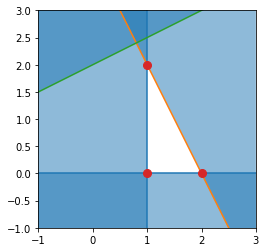

In [124]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot('111', aspect='equal')
xlim, ylim = (-1, 3), (-1, 3)
ax.set_xlim(xlim)
ax.set_ylim(ylim)
x = np.linspace(-1, 3, 100)
symbols = ['-', '+', 'x', '*']
signs = [0, 0, -1, -1]
fmt = {"color": None, "edgecolor": "b", "alpha": 0.5}
for h, sym, sign in zip(halfspaces, symbols, signs):
    hlist = h.tolist()
#     fmt["hatch"] = sym
    if h[1]== 0:
        ax.axvline(-h[2]/h[0], label='{}x+{}y+{}=0'.format(*hlist))
        xi = np.linspace(xlim[sign], -h[2]/h[0], 100)
        ax.fill_between(xi, ylim[0], ylim[1], **fmt)
    else:
        ax.plot(x, (-h[2]-h[0]*x)/h[1], label='{}x+{}y+{}=0'.format(*hlist))
        ax.fill_between(x, (-h[2]-h[0]*x)/h[1], ylim[sign], **fmt)
x, y = zip(*hs.intersections)
ax.plot(x, y, 'o', markersize=8)
plt.show()

(0.95, 2.05, -0.1, 2.1)

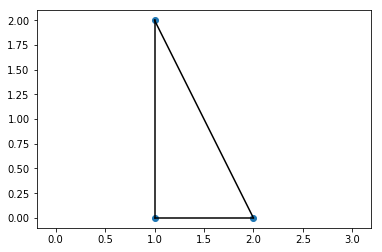

In [125]:
from scipy.spatial import ConvexHull

xlim, ylim = (-1, 3), (-1, 3)

points = hs.intersections
hull = ConvexHull(points)
import matplotlib.pyplot as plt
plt.plot(points[:,0], points[:,1], 'o')
for simplex in hull.simplices:
    plt.plot(points[simplex, 0], points[simplex, 1], 'k-')
plt.axis('equal')

In [188]:
# random points at least 2r apart
m = 1
np.random.seed(3)
x = [np.random.uniform(size=(2))]
r = 0.16
while(len(x) < m):
    p = np.random.uniform(size=(2))
    if min(np.abs(p-a).sum() for a in x) > 2*r:
        x.append(p)
# r = 0.145
epsilon = r/2

X = torch.Tensor(np.array(x))
torch.manual_seed(1)
y = (torch.rand(m)+0.5).long()

In [189]:
import sys
sys.path.append("../")
from convex_adversarial import robust_loss

torch.manual_seed(1)
robust_net = nn.Sequential(
    nn.Linear(2,100),
    nn.ReLU(),
    nn.Linear(100,100),
    nn.ReLU(),
    nn.Linear(100,100),
    nn.ReLU(),
    nn.Linear(100,100),
    nn.ReLU(),
    nn.Linear(100,2)
)
# data = []
# opt = optim.Adam(robust_net.parameters(), lr=1e-3)
# for i in range(1000):
#     robust_ce, robust_err = robust_loss(robust_net, epsilon, Variable(X), Variable(y))
#     out = robust_net(Variable(X))
#     l2 = nn.CrossEntropyLoss()(out, Variable(y))
#     err = (out.max(1)[1].data != y).float().mean()
#     data.append([l2.item(), robust_ce.item(), err, robust_err])
#     if i % 100 == 0:
#         print(robust_ce.item(), robust_err)
#     opt.zero_grad()
#     (robust_ce).backward()
#     opt.step()

# print(l2.data.item(), robust_ce.item(), robust_err)

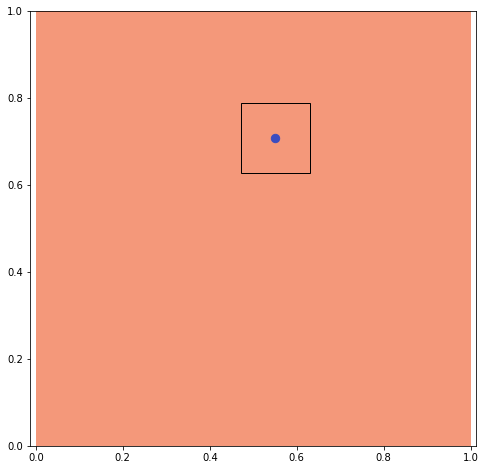

In [190]:
XX, YY = np.meshgrid(np.linspace(0, 1, 100), np.linspace(0, 1, 100))
X0 = Variable(torch.Tensor(np.stack([np.ravel(XX), np.ravel(YY)]).T))
y0 = robust_net(X0)
ZZ = (y0[:,0] - y0[:,1]).resize(100,100).data.numpy()

fig, ax = plt.subplots(figsize=(8,8))
ax.contourf(XX,YY,-ZZ, cmap="coolwarm", levels=np.linspace(-1000,1000,3))
ax.scatter(X.numpy()[:,0], X.numpy()[:,1], c=y.numpy(), cmap="coolwarm", s=70)
ax.axis("equal")
ax.axis([0,1,0,1])
for a in x:
    ax.add_patch(patches.Rectangle((a[0]-r/2, a[1]-r/2), r, r, fill=False))


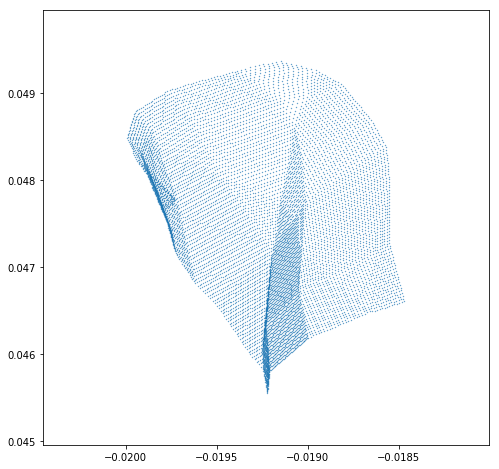

In [205]:
fig, ax = plt.subplots(figsize=(8,8))
for a in x:
    XX, YY = np.meshgrid(np.linspace(a[0] - r/2, a[0] + r/2, 100), np.linspace(a[1] - r/2, a[1] + r/2, 100))
    X0 = Variable(torch.Tensor(np.stack([np.ravel(XX), np.ravel(YY)]).T))
    y0 = robust_net(X0).data.numpy()
    ax.scatter(y0[:,0], y0[:,1], cmap="coolwarm", s=.1)
    break

In [192]:
from convex_adversarial import DualNetBounds

dual = DualNetBounds(robust_net, Variable(X), epsilon)

In [236]:
hyperPlanes = []
thetas = [0, 45, 90, 135]
for kk in range(len(thetas)):
    num_classes = 2
#     theta = np.random.randint(0,90,[1])
    theta = np.array(thetas[kk])
    print(theta)
    theta = np.pi*theta/180
    theta = theta.repeat(num_classes)

    c = Variable(torch.tensor([np.cos(theta), np.sin(theta)]).t().type_as(X.data)[y.data].unsqueeze(1))\
                                        .expand([y.data.shape[0],num_classes, num_classes])
    #- torch.tensor([np.cos(theta), np.sin(theta)]).type_as(X.data).unsqueeze(0))
    f_1 = dual.g(c)
    f_2 = dual.g(-c)
    hyperPlanes.append( (c[:,0], f_1, f_2 ))

0
45
90
135


In [237]:
A = np.zeros([y.data.shape[0], len(hyperPlanes)*2, num_classes+1])
for it_hyper, plane in enumerate(hyperPlanes):
    c = plane[0]
    for it_sample in range(y.data.shape[0]):
        f1 = plane[1][it_sample]
        f2 = plane[2][it_sample]
        
        A[it_sample, 2*it_hyper,:2] = c[it_sample].numpy()
        A[it_sample, 2*it_hyper + 1,:2] = c[it_sample].numpy()

        P0 = c[it_sample]*f1.data
        P1 = c[it_sample]*f2.data
        A[it_sample, 2*it_hyper + 1, 2] = - (c[it_sample][0]*P0[:1] + c[it_sample][1]*P0[1:]).numpy()
        A[it_sample, 2*it_hyper + 1, 2] = - (c[it_sample][0]*P1[:1] + c[it_sample][1]*P1[1:]).numpy()


In [238]:
from scipy.spatial import HalfspaceIntersection
halfspaces = A[0]

from scipy.optimize import linprog
from matplotlib.patches import Circle
norm_vector = np.reshape(np.linalg.norm(halfspaces[:, :-1], axis=1),
    (halfspaces.shape[0], 1))

# c = np.zeros((halfspaces.shape[1],))
# c[-1] = -1
# Au = np.hstack((halfspaces[:, :-1], norm_vector))
# bu = - halfspaces[:, -1:]
# res = linprog(c, A_ub=Au, b_ub=bu)
# print(res)
# feasible_point = res.x[:-1]
# feasible_point = np.array([5., -2.])
# hs = HalfspaceIntersection(halfspaces, feasible_point)

In [239]:
halfspaces

array([[ 1.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 1.00000000e+00,  0.00000000e+00, -1.72496382e-02],
       [ 7.07106769e-01,  7.07106769e-01,  0.00000000e+00],
       [ 7.07106769e-01,  7.07106769e-01,  2.24166736e-02],
       [ 6.12323426e-17,  1.00000000e+00,  0.00000000e+00],
       [ 6.12323426e-17,  1.00000000e+00,  5.03241532e-02],
       [-7.07106769e-01,  7.07106769e-01,  0.00000000e+00],
       [-7.07106769e-01,  7.07106769e-01,  4.95403260e-02]])

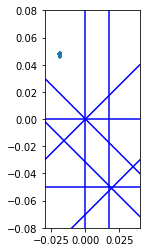

In [244]:
# import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot('111', aspect='equal')
xlim, ylim = (-.03, .04), (-1, 4)
xx = np.linspace(*xlim, 100)
# signs = [0, 0, -1, -1]
fmt = {"color": None, "edgecolor": "b", "alpha": 0.5}
for h in halfspaces:
    hlist = h.tolist()
    if h[1]== 0:
        ax.axvline(-h[2]/h[0], c='b',label='{}x+{}y+{}=0'.format(*hlist))
    else:
        ax.plot(xx, (-h[2]-h[0]*xx)/h[1], c='b', label='{}x+{}y+{}=0'.format(*hlist))

ax.axis([*xlim, -0.080, 0.08])

for a in x:
    XX, YY = np.meshgrid(np.linspace(a[0] - r/2, a[0] + r/2, 100), np.linspace(a[1] - r/2, a[1] + r/2, 100))
    X0 = Variable(torch.Tensor(np.stack([np.ravel(XX), np.ravel(YY)]).T))
    y0 = robust_net(X0).data.numpy()
    ax.scatter(y0[:,0], y0[:,1], cmap="coolwarm", s=.1)

(0.95, 2.05, -0.1, 2.1)

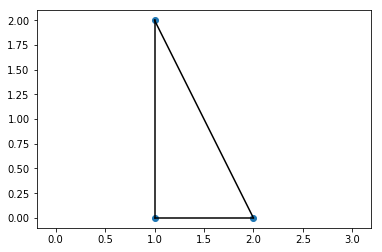

In [245]:
from scipy.spatial import ConvexHull

xlim, ylim = (-1, 3), (-1, 3)

points = hs.intersections
hull = ConvexHull(points)
import matplotlib.pyplot as plt
plt.plot(points[:,0], points[:,1], 'o')
for simplex in hull.simplices:
    plt.plot(points[simplex, 0], points[simplex, 1], 'k-')
plt.axis('equal')